In [70]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [71]:
def load_debug_arrays(filename="debug_arrays.h5"):
    """Load all arrays from HDF5 file into separate variables.
    
    Returns:
        tuple: (V_qmunu, Gkval_mu_nu, psi_l_rmu, psi_r_rmu, sigma_munu, sigma_ij)
    """
    with h5py.File(filename, 'r') as f:
        V_qmunu = f['coulomb/V_qmunu'][:]
        Gkval_mu_nu = f['green/Gkval_mu_nu'][:]
        psi_l_rmu = f['wavefunc/psi_l_rmu_out'][:]
        psi_r_rmu = f['wavefunc/psi_r_rmu_out'][:]
        sigma_munu = f['sigma/sigma_x_kbar_munu'][:]
        sigma_ij = f['sigma/sigma_x_kbar_ij'][:]
        
    return V_qmunu, Gkval_mu_nu, psi_l_rmu, psi_r_rmu, sigma_munu, sigma_ij

In [72]:
V_qmunu, Gkval_mu_nu, psi_l_rmu, psi_r_rmu, sigma_munu, sigma_ij = load_debug_arrays()

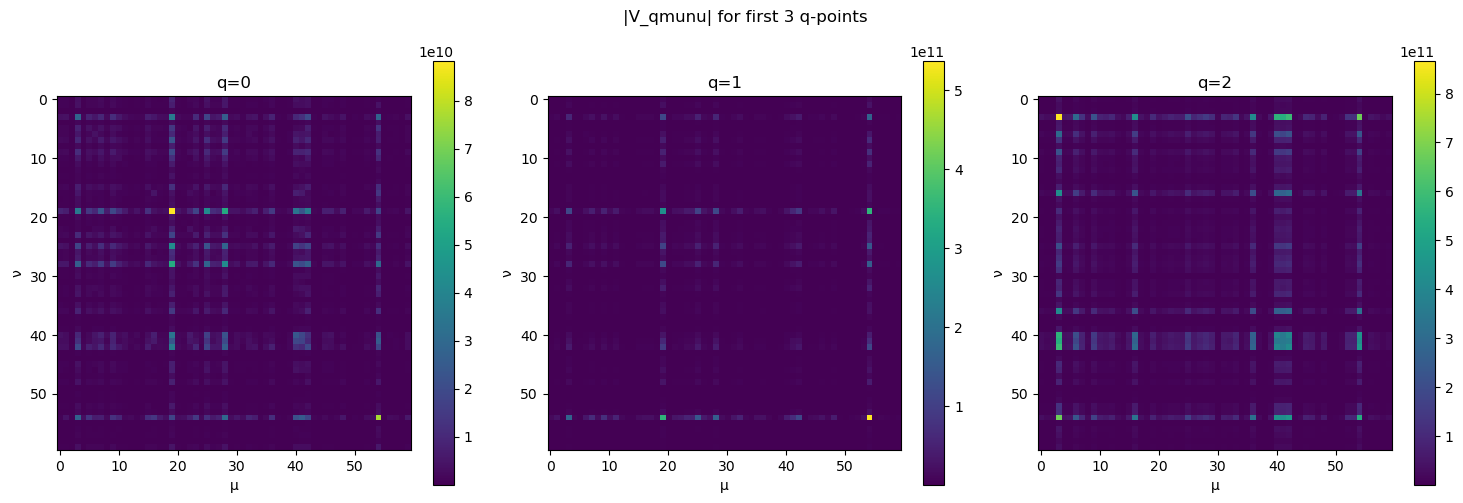

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('|V_qmunu| for first 3 q-points')

for i in range(3):
    im = axes[i].imshow(np.abs(V_qmunu[i,:60,:60]), cmap='viridis')
    axes[i].set_title(f'q={i}')
    plt.colorbar(im, ax=axes[i])
    axes[i].set_xlabel('μ')
    axes[i].set_ylabel('ν')

plt.tight_layout()
plt.show()

In [65]:
plt.plot(np.abs())

[0 1 2 2 3 1 1 2 3]


c:\Users\jackm\miniconda3\envs\cudaenv\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\jackm\miniconda3\envs\cudaenv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


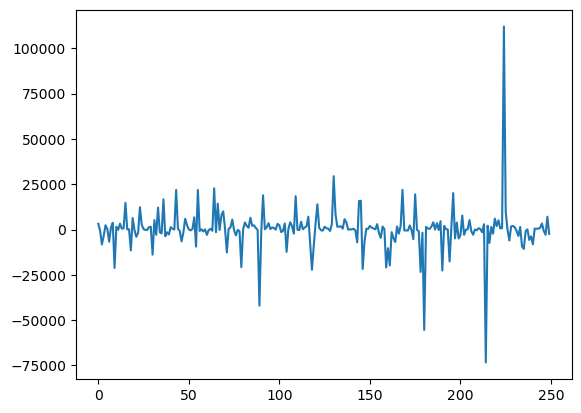

In [14]:
plt.plot(V_qmunu[0,0])

In [15]:
vcoul = h5py.File("eps0mat.h5",'r')['eps_header/gspace/vcoul'][:]


In [16]:
vcoul

array([[2.33255708e+05, 6.50256939e+02, 6.50256939e+02, 1.11819706e+00,
        1.11819706e+00, 7.22520025e+01, 7.22520025e+01, 2.79550271e-01,
        2.79550271e-01, 1.71064844e+01, 1.70893610e+01, 1.70552167e+01,
        1.70381956e+01, 1.70893609e+01, 1.70552166e+01, 1.62570241e+01,
        1.62570241e+01, 1.62415580e+01, 1.62415580e+01, 1.62107140e+01,
        1.62107140e+01, 1.61953359e+01, 1.61953359e+01, 1.62415580e+01,
        1.62415580e+01, 1.62107140e+01, 1.62107140e+01, 1.41490893e+01,
        1.41490893e+01, 1.41373727e+01, 1.41373727e+01, 1.41139976e+01,
        1.41139976e+01, 1.41023390e+01, 1.41023390e+01, 1.41373726e+01,
        1.41373726e+01, 1.41139975e+01, 1.41139975e+01, 2.60107564e+01,
        2.60107564e+01, 1.16348141e+01, 1.16348141e+01, 1.16268903e+01,
        1.16268903e+01, 1.16110750e+01, 1.16110750e+01, 1.16031834e+01,
        1.16031834e+01, 1.16268903e+01, 1.16268903e+01, 1.16110749e+01,
        1.16110749e+01, 9.31691942e+00, 9.31691942e+00, 9.311837

In [5]:
from cohsex_noisdf import get_V_qG
import numpy as np
import cupy as cp
from wfnreader import WFNReader
from epsreader import EPSReader
import symmetry_maps
import matplotlib.pyplot as plt


In [38]:
wfn = WFNReader("WFN.h5")
wfnq = WFNReader("WFNq.h5")
sym = symmetry_maps.SymMaps(wfn)
eps0 = EPSReader('eps0mat.h5')
epsmat = EPSReader('epsmat.h5')

In [27]:
V_qG, wcoul0 = get_V_qG(wfn, sym, eps0.qpts[0], cp, eps0.epshead, 2)


[0.001 0.    0.   ]
(3,)
(3,)
(3,)
(3,)
V_q=0,G=0 from miniBZ monte carlo: 1654.8758
W_q=0(G=G'=0) from miniBZ monte carlo: 390.7446


In [50]:
# these two cells prove that this indexing method correctly reorders v from wfn order to eps order

iqbar=2
iqbareps = 1
eps = epsmat

G_qbar_comps = np.asarray(wfn.get_gvec_nk(iqbar), dtype=np.int32)
vcoul_G_q_comps_compare = np.dot(G_qbar_comps, np.array([1, 1000, 1000000]))
eps_G_qbar_comps = np.asarray(eps.unfold_eps_comps(iqbareps, sym.sym_mats_k[0], np.array([0.,0.,0.])),dtype=np.int32)
eps_G_qbar_comps_compare = np.dot(eps_G_qbar_comps, np.array([1, 1000, 1000000]))
perm = np.argsort(vcoul_G_q_comps_compare)
sorted_vcoul_compare = vcoul_G_q_comps_compare[perm]
 # For each eps key, find its location in the sorted vcoul array:
idx = np.searchsorted(sorted_vcoul_compare, eps_G_qbar_comps_compare)
 # (Optional) Verify that every eps key is found in vcoul:
if not np.all(sorted_vcoul_compare[idx] == eps_G_qbar_comps_compare):
    raise ValueError("Not all eps keys were found in vcoul keys.")
 # Map back to the original indices in vcoul:
vcoul_eps_inds = perm[idx]
v_qG_epsorder = np.zeros(eps_G_qbar_comps.shape[0],dtype=np.complex128) # values are real, just use cplx dtype
v_qG_epsorder[:] = np.asarray(V_qG.get()[iqbar][vcoul_eps_inds])

(0.0, 50.0)

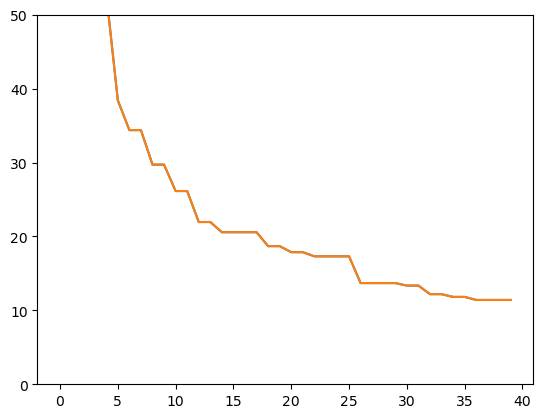

In [51]:
#plt.plot([1,:30].get())
#plt.plot(V_qG.get()[1][:30])
plt.plot(v_qG_epsorder[:40])
plt.plot(eps.vcoul[0,:40])
plt.ylim(0,50)

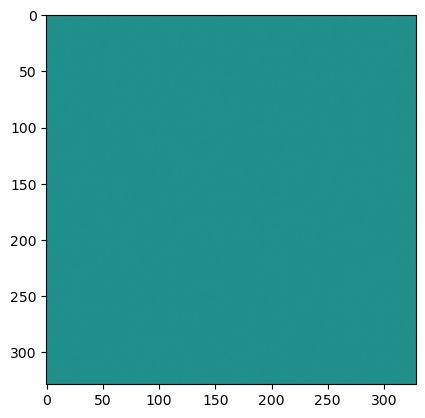

In [54]:
epstmpmat = eps.get_eps_minus_delta_matrix(iqbareps) * v_qG_epsorder[:,np.newaxis]
plt.imshow((epstmpmat - epstmpmat.conj().T).real,vmin=-1e-4,vmax=1e-4)



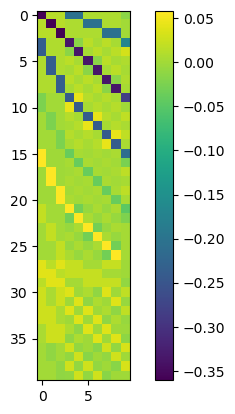

In [49]:
plt.imshow(eps.get_eps_minus_delta_matrix(iqbar).real[:40,:10])
plt.colorbar()

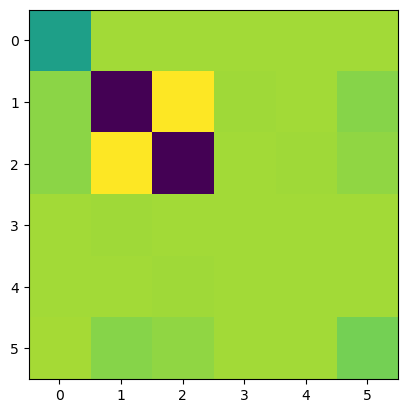

In [37]:
plt.imshow((eps0.get_eps_minus_delta_matrix(iqbar)[:6,:6] * v_qG_epsorder[:6][:,np.newaxis]).real)


In [55]:
x = np.array([1,2,3])
x[:0] = 0
x


array([1, 2, 3])

In [58]:
np.diag(eps.get_eps_minus_delta_matrix(0))

array([-0.50806368+3.03576608e-18j, -0.44172414+0.00000000e+00j,
       -0.44172416-5.14996032e-19j, -0.33870216-1.62630326e-18j,
       -0.33870222+2.49366500e-18j, -0.31695267+9.75781955e-19j,
       -0.30014071+1.50519065e-18j, -0.30014071+9.31736242e-19j,
       -0.27110746+3.15382874e-19j, -0.27110761+1.62630326e-19j,
       -0.25450904+1.35020567e-18j, -0.25450922+2.43945489e-18j,
       -0.23739544+4.74631686e-19j, -0.23739512+9.24959978e-19j,
       -0.22768188-3.32883948e-19j, -0.22768172+1.43826194e-18j,
       -0.22768177-1.03643746e-18j, -0.22768165+1.88041314e-19j,
       -0.20508079+1.04625795e-18j, -0.20508113-1.69745403e-18j,
       -0.20017439+2.87164228e-19j, -0.20017472-3.79470760e-19j,
       -0.2000126 +7.14111640e-19j, -0.20001225+2.04981973e-18j,
       -0.2000125 +5.32027681e-19j, -0.20001262+7.86046575e-19j,
       -0.16292871-1.43861598e-19j, -0.16292863-2.60886148e-19j,
       -0.16292886+4.89851396e-19j, -0.16292859+1.60766853e-18j,
       -0.15929545+9.6662

In [60]:
eps0._file.close()
eps._file.close()
